In [1]:
import keras
from keras.initializers import Constant
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Activation, Dense, Flatten, Add, Concatenate
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Lambda, UpSampling2D
from keras.layers import ReLU, LeakyReLU, PReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import keras.backend as K
print(K.image_data_format())
K.set_learning_phase(1) #for batchnorm

import tensorflow as tf
#tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


channels_first


In [4]:

bnopt = {
    'axis':1,
    'epsilon':1e-5,
    'center':True
}

def kconv3x3(out_planes, stride=1, name=None):
    return Conv2D(out_planes, kernel_size=3, strides=stride, padding='same', use_bias=False, name=name)

def kBasicBlock(inplanes, outplanes, batchNorm_type=0, name=None):
    x = Input(shape=(inplanes, None, None))
    out = kconv3x3(outplanes, 1, name='conv1')(x)
    if batchNorm_type == 0:
        out = BatchNormalization(**bnopt, name='bn1')(out)
    elif batchNorm_type == 1:
        out = InstanceNormalization(**bnopt, name='in1')(out)
    out = Activation('relu')(out)
    out = kconv3x3(outplanes, 1, name='conv2')(out)
    if batchNorm_type == 0:
        out = BatchNormalization(**bnopt, name='bn2')(out)
    elif batchNorm_type == 1:
        out = InstanceNormalization(**bnopt, name='in2')(out)
    shortcuts = Conv2D(outplanes, kernel_size=1, strides=1, use_bias=False, name='shortcuts')(x)
    if (inplanes != outplanes):
        out = Add()([out, shortcuts])
    else:
        out = Add()([out, x])
    out = Activation('relu')(out)
    return Model(inputs=x, outputs=out, name=name)

def klightingNet(ncInput, ncOutput, ncMiddle, name=None): #27, 9, 128 #len(zs), #SH coeff, ...
    innerFeat = Input(shape=(None, None, None)) #155,32,32
    x = Lambda(lambda x_: K.slice(x_, (0,0,0,0), (-1,ncInput,-1,-1)))(innerFeat) #27,32,32
    #row, col = K.shape(x)[2], K.shape(x)[3] #32,32

    feat = Lambda(lambda x_: K.mean(x_, axis=(2,3), keepdims=True))(x) #27,32,32
    pred_light = Conv2D(ncMiddle, kernel_size=1, strides=1, use_bias=False, name='predict_FC1')(feat) #128,32,32
    pred_light = PReLU(shared_axes=[2,3], name='predict_relu1')(pred_light) #shared_axes solves bug in tf 1.13. not sure of side-effect.
    pred_light = Conv2D(ncOutput, kernel_size=1, strides=1, use_bias=False, name='predict_FC2')(pred_light) #9,32,32

    target_light = Input(shape=(ncOutput, None, None)) #9,1,1
    upFeat = Conv2D(ncMiddle, kernel_size=1, strides=1, use_bias=False, name='post_FC1')(target_light) #128,1,1
    upFeat = PReLU(shared_axes=[2,3], name='post_relu1')(upFeat) #shared_axes solves bug in tf 1.13. not sure of side-effect.
    upFeat = Conv2D(ncInput, kernel_size=1, strides=1, use_bias=False, name='post_FC2')(upFeat) #27,1,1
    upFeat = ReLU()(upFeat)
    upFeat = Lambda(lambda x_: K.tile(x_, (1, 1, 32, 32)))(upFeat) #27,32,32 #had to hard-code this
    #upFeat = Lambda(lambda x_: K.tile(x_, (1, 1, row, col)))(upFeat) #27,32,32?

    x2 = Lambda(lambda x_: K.slice(x_, (0,ncInput,0,0), (-1,-1,-1,-1)))(innerFeat) #27,32,32
    xout = Concatenate(axis=1)([upFeat, x2]) #155,32,32
    return Model(inputs=[innerFeat, target_light], outputs=[xout, pred_light], name=name) #(155, 32, 32), (9, 1, 1)

def kHourglassBlock(inplane, mid_plane, middleNet, name=None): #64, 155, klnet(27,9,128)
    x = Input(shape=(inplane, None, None)) #64,64,64
    target_light = Input(shape=(9, None, None)) #9,1,1 #hardcoded -> nout
    out_upper = kBasicBlock(inplane, inplane, batchNorm_type=1, name='upper')(x) #64,64,64
    out_lower = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='downsample')(x) #64,32,32
    out_lower = kBasicBlock(inplane, mid_plane, name='low1')(out_lower) #155,32,32 (OK)
    out_lower, pred_light = middleNet([out_lower, target_light]) #(155,32,32), (9,1,1) -> (155,32,32), (9,1,1)
    out_lower = kBasicBlock(mid_plane, inplane, batchNorm_type=1, name='low2')(out_lower) #64,32,32
    out_lower = UpSampling2D(size=(2, 2), name='upsample')(out_lower) #64,64,64
    out = Add()([out_lower, out_upper]) #64,64,64
    return Model(inputs=[x, target_light], outputs=[out, pred_light], name=name) #(64,64,64), (9,1,1)

def kHourglassNet(baseFilter=16, name=None):
    x = Input(shape=(1, None, None)) #1,512,512
    target_light = Input(shape=(9, None, None)) #9,1,1 #hardcoded -> nout
    feat = keras.layers.ZeroPadding2D(padding=(2, 2))(x)
    feat = Conv2D(baseFilter, kernel_size=5, strides=1, padding='valid', name='pre_conv')(feat)
    feat = BatchNormalization(**bnopt, name='pre_bn')(feat)
    feat = Activation('relu')(feat)

    ncPre = baseFilter
    ncLight = 27
    ncOutLight = 9
    ncHG3 = baseFilter
    ncHG2 = 2*baseFilter
    ncHG1 = 4*baseFilter
    ncHG0 = 8*baseFilter + ncLight

    klnet = klightingNet(ncLight, ncOutLight, 128, name='klnet')
    HG0 = kHourglassBlock(ncHG1, ncHG0, klnet, name='HG0')
    HG1 = kHourglassBlock(ncHG2, ncHG1, HG0, name='HG1')
    HG2 = kHourglassBlock(ncHG3, ncHG2, HG1, name='HG2')
    HG3 = kHourglassBlock(ncPre, ncHG3, HG2, name='HG3')
    feat, out_light = HG3([feat, target_light])

    feat = Conv2D(ncPre, kernel_size=3, strides=1, padding='same', name='conv_1')(feat)
    feat = BatchNormalization(**bnopt, name='bn_1')(feat)
    feat = Activation('relu')(feat)

    feat = Conv2D(ncPre, kernel_size=1, strides=1, padding='valid', name='conv_2')(feat)
    feat = BatchNormalization(**bnopt, name='bn_2')(feat)
    feat = Activation('relu')(feat)

    feat = Conv2D(ncPre, kernel_size=1, strides=1, padding='valid', name='conv_3')(feat)
    feat = BatchNormalization(**bnopt, name='bn_3')(feat)
    feat = Activation('relu')(feat)

    out_img = Conv2D(1, kernel_size=1, strides=1, padding='valid', name='output')(feat)
    out_img = Activation('sigmoid')(out_img)
    return Model(inputs=[x, target_light], outputs=[out_img, out_light], name=name)


In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary
# #torch.backends.cudnn.enabled = True

# import sys
# sys.path.append('model')
# sys.path.append('utils')
# from utils_SH import *
# from defineHourglass_512_gray_skip import *

# def tt(x):
#     return torch.tensor(x).float()

# def npa(x):
#     return x.detach().numpy()

# def pconv2d_to_kconv2d(pconv, kconv): #assuming keras channels_first
#     pweights = npa(pconv.weight)
#     kweights = np.transpose(pweights, (2,3,1,0))
#     if (pconv.bias is None):
#         kconv.set_weights([kweights])
#     else:
#         pbias = npa(pconv.bias)
#         kconv.set_weights([kweights, pbias])
#     return kconv

# def pbatchnorm_to_kbatchnorm(player, klayer):
#     pweights = npa(player.weight)
#     kweights = klayer.get_weights()
#     kweights[0] = pweights
#     if (player.bias is not None):
#         kweights[1] = npa(player.bias)
#     klayer.set_weights(kweights)
#     return klayer

# def pbblock_to_kbblock(pmodel, kmodel): #fix bn1 and bn2 
#     klayer_names = [layer.name for layer in kmodel.layers]
#     pconv2d_to_kconv2d(pmodel.conv1, kmodel.get_layer('conv1'))
#     pconv2d_to_kconv2d(pmodel.conv2, kmodel.get_layer('conv2'))
#     #if (pmodel.inplanes != pmodel.outplanes):
#     if ('shortcuts' in klayer_names):
#         pconv2d_to_kconv2d(pmodel.shortcuts, kmodel.get_layer('shortcuts'))
#     if ('bn1' in klayer_names) and ('bn2' in klayer_names):
#         pbatchnorm_to_kbatchnorm(pmodel.bn1, kmodel.get_layer('bn1'))
#         pbatchnorm_to_kbatchnorm(pmodel.bn2, kmodel.get_layer('bn2'))
#     return kmodel

# def pprelu_to_kprelu(pprelu, kprelu):
#     alpha = npa(pprelu.weight)[0]
#     kprelu.set_weights([np.ones_like(kprelu.get_weights()[0])*alpha])
#     return kprelu

# def plightnet_to_klightnet(pmodel, kmodel):
#     pconv2d_to_kconv2d(pmodel.predict_FC1, kmodel.get_layer('predict_FC1'))
#     pconv2d_to_kconv2d(pmodel.predict_FC2, kmodel.get_layer('predict_FC2'))
#     pprelu_to_kprelu(pmodel.predict_relu1, kmodel.get_layer('predict_relu1'))

#     pconv2d_to_kconv2d(pmodel.post_FC1, kmodel.get_layer('post_FC1'))
#     pconv2d_to_kconv2d(pmodel.post_FC2, kmodel.get_layer('post_FC2'))
#     pprelu_to_kprelu(pmodel.post_relu1, kmodel.get_layer('post_relu1'))
#     return kmodel

# def phgblock_to_khgblock(pmodel, kmodel):
#     klayer_names = [layer.name for layer in kmodel.layers]
#     pbblock_to_kbblock(pmodel.upper, kmodel.get_layer('upper'))
#     pbblock_to_kbblock(pmodel.low1, kmodel.get_layer('low1'))
#     pbblock_to_kbblock(pmodel.low2, kmodel.get_layer('low2'))
#     if ('klnet' in klayer_names):
#         plightnet_to_klightnet(pmodel.middle, kmodel.get_layer('klnet'))
#     else:
#         hg_layers = [s for s in klayer_names if 'HG' in s]
#         phgblock_to_khgblock(pmodel.middle, kmodel.get_layer(hg_layers[0]))
#     return kmodel

# def phgnet_to_khgnet(pmodel, kmodel):
#     pconv2d_to_kconv2d(pmodel.pre_conv, kmodel.get_layer('pre_conv'))
#     pbatchnorm_to_kbatchnorm(pmodel.pre_bn, kmodel.get_layer('pre_bn'))
#     phgblock_to_khgblock(pmodel.HG3, kmodel.get_layer('HG3'))
#     pconv2d_to_kconv2d(pmodel.conv_1, kmodel.get_layer('conv_1'))
#     pbatchnorm_to_kbatchnorm(pmodel.bn_1, kmodel.get_layer('bn_1'))
#     pconv2d_to_kconv2d(pmodel.conv_2, kmodel.get_layer('conv_2'))
#     pbatchnorm_to_kbatchnorm(pmodel.bn_2, kmodel.get_layer('bn_2'))
#     pconv2d_to_kconv2d(pmodel.conv_3, kmodel.get_layer('conv_3'))
#     pbatchnorm_to_kbatchnorm(pmodel.bn_3, kmodel.get_layer('bn_3'))
#     pconv2d_to_kconv2d(pmodel.output, kmodel.get_layer('output'))
#     return kmodel

# modelFolder = 'trained_model/'
# lightFolder = 'data/example_light/'
# saveFolder = 'result'

# pmodel = HourglassNet()
# pmodel.load_state_dict(torch.load(os.path.join(modelFolder, 'trained_model_03.t7')))
# #pmodel.cuda()
# #pmodel.train(False)


<All keys matched successfully>

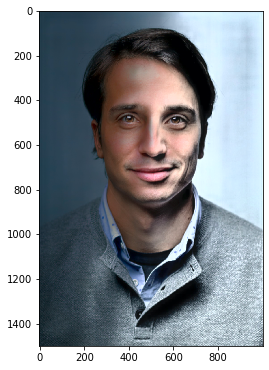

In [10]:
import cv2, os

modelFolder = 'trained_model/'
lightFolder = 'data/example_light/'
saveFolder = 'result'

img = cv2.imread('data/online_guy.jfif')
row, col, _ = img.shape
img = cv2.resize(img, (512, 512))
Lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

inputL = Lab[:, :, 0]
inputL = inputL.astype(np.float32)/255.0
inputL = inputL.transpose((0,1))
inputL = inputL[None, None, ...]
### inputL = torch.from_numpy(inputL)

K.set_learning_phase(1)
kmodel = kHourglassNet(name='hgnet')
# kmodel = phgnet_to_khgnet(pmodel, kmodel)

plt.figure(figsize=(4,10))

for i in range(1):
    sh = np.loadtxt(os.path.join(lightFolder, 'rotate_light_{:02d}.txt'.format(i)))[0:9]
    sh = 0.7 * sh
    sh = np.reshape(sh, (1, 9, 1, 1)).astype(np.float32)

    kimg, ksh = kmodel.predict([inputL, sh])
    kimg = kimg[0].transpose((1,2,0))
    kimg = np.squeeze(kimg)
    kimg = (kimg*255.0).astype(np.uint8)
    Lab[:,:,0] = kimg
    resultLab = cv2.cvtColor(Lab, cv2.COLOR_LAB2BGR)
    resultLab = cv2.resize(resultLab, (col, row))
    resultLab = cv2.cvtColor(resultLab, cv2.COLOR_BGR2RGB)
    plt.imshow(resultLab)
    #cv2.imwrite('ponline_guy_traintrue_new.jpg', resultLab)
    #cv2.imwrite(os.path.join(saveFolder, 'pytorch_online_guy_{:02d}.jpg'.format(i)), resultLab)
